# Digit Recognition

Sudoku dataset downloaded from https://github.com/wichtounet/sudoku_dataset

In [58]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

import image_processing_utils as ip_utils

%matplotlib inline

In [2]:
train_paths = []
test_paths = []

with open('data/train.desc') as f:
    for img in f.readlines():
        train_paths.append('data/train/' + img.strip()[7:-4])
        
with open('data/test.desc') as f:
    for img in f.readlines():
        test_paths.append('data/test/' + img.strip()[7:-4])

## Convert train images to csv

1. Read image and corresponding ".dat" file containing target digits.
2. Extract digits from the image using `image_to_grid.convert(img)`. Extracted digits are in the form of 28x28 image.
3. If digit is present in cell (target non-zero), add digit and target to CSV. Each row in CSV will have 785 columns. First column is target digit and remaining 784 are flattened pixels of digit image.

<center><h2>Original image</h2></center>

![](images/sudoku1.jpeg)  <br><br>

<center><h2>Extracted digits</h2></center>

![](images/sudoku1_extracted_digits.jpeg)

In [3]:
train_data = []
for path in tqdm(train_paths):
    img = cv2.imread(path + '.jpg', cv2.IMREAD_GRAYSCALE)
    digits = ip_utils.convert(img)
    target = []
    with open(path + '.dat') as f:
        for line in f.readlines()[2:]:
            target.extend(map(int, line.strip().split()))
    for digit, t in zip(digits, target):
        if t != 0:
            train_data.append(np.concatenate(([t], np.array(digit).flatten())))

100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:29<00:00,  5.49it/s]


In [4]:
train_df = pd.DataFrame(train_data)
print(train_df.shape)
print(train_df.head())
train_df.to_csv('data/train.csv', index=False, header=False)

(4656, 785)
   0    1    2    3    4    5    6    7    8    9   ...   775  776  777  778  \
0    7    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
1    8    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
2    9    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
3    3    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
4    1    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


Same for test data

In [6]:
test_data = []
for path in tqdm(test_paths):
    img = cv2.imread(path + '.jpg', cv2.IMREAD_GRAYSCALE)
    digits = ip_utils.convert(img)
    target = []
    with open(path + '.dat') as f:
        for line in f.readlines()[2:]:
            target.extend(map(int, line.strip().split()))
    for digit, t in zip(digits, target):
        if t != 0:
            test_data.append(np.concatenate(([t], np.array(digit).flatten())))

test_df = pd.DataFrame(test_data)
print(test_df.shape)
print(test_df.head())
test_df.to_csv('data/test.csv', index=False, header=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.30it/s]


(1156, 785)
   0    1    2    3    4    5    6    7    8    9   ...   775  776  777  778  \
0    8    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
1    7    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
2    9    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
4    6    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


In [7]:
x_train, y_train = train_df.iloc[:, 1:], train_df.iloc[:, 0]
x_test, y_test = test_df.iloc[:, 1:], test_df.iloc[:, 0]

### Normalize and reshape

In [8]:
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_test = x_test.values.reshape(-1, 28, 28, 1)

Target: 3


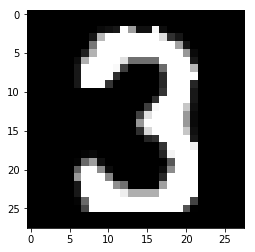

In [11]:
idx = random.randint(0, 4655)
plt.imshow(x_train[idx].reshape(28, 28), cmap='gray')
print('Target:', y_train.iloc[idx])

In [10]:
y_train.value_counts()

8    567
3    538
7    535
9    531
4    515
5    509
1    506
2    501
6    454
Name: 0, dtype: int64

### Label encoding

In [12]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Training

In [13]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [14]:
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

### Data Augmentation

In [16]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)
datagen.fit(x_train)

In [17]:
epochs = 30
batch_size = 32
steps_per_epoch = x_train.shape[0] // batch_size
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, verbose=2,
                              validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch, callbacks=[lr_reduction])

Epoch 1/30
 - 35s - loss: 1.3837 - acc: 0.5013 - val_loss: 0.2869 - val_acc: 0.9100
Epoch 2/30
 - 33s - loss: 0.4556 - acc: 0.8616 - val_loss: 0.2272 - val_acc: 0.9394
Epoch 3/30
 - 33s - loss: 0.2937 - acc: 0.9121 - val_loss: 0.2153 - val_acc: 0.9412
Epoch 4/30
 - 37s - loss: 0.2192 - acc: 0.9371 - val_loss: 0.2219 - val_acc: 0.9472
Epoch 5/30
 - 39s - loss: 0.1809 - acc: 0.9474 - val_loss: 0.2305 - val_acc: 0.9455
Epoch 6/30
 - 39s - loss: 0.1761 - acc: 0.9476 - val_loss: 0.1791 - val_acc: 0.9464
Epoch 7/30
 - 39s - loss: 0.1462 - acc: 0.9565 - val_loss: 0.1943 - val_acc: 0.9481
Epoch 8/30
 - 34s - loss: 0.1530 - acc: 0.9545 - val_loss: 0.1943 - val_acc: 0.9455
Epoch 9/30
 - 33s - loss: 0.1485 - acc: 0.9558 - val_loss: 0.1949 - val_acc: 0.9481
Epoch 10/30
 - 33s - loss: 0.1347 - acc: 0.9595 - val_loss: 0.1962 - val_acc: 0.9472

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/30
 - 33s - loss: 0.1129 - acc: 0.9647 - val_loss: 0.1891 - val_acc: 

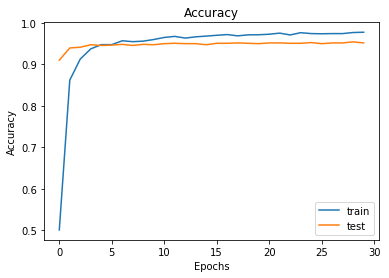

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

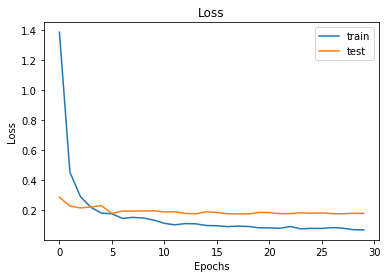

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

In [20]:
model.save('dr_unsolved_data.h5')

---

# Extended data set

Using artificially solved sudoku images instead of unsolved images to get more variations of digits.

For example: 

![](data/train_solved/image202.jpg)

In [21]:
train_solved_paths = []
test_solved_paths = []

with open('data/train_solved.desc') as f:
    for img in f.readlines():
        train_solved_paths.append('data/train_solved/' + img.strip()[6:-4])
        
with open('data/test_solved.desc') as f:
    for img in f.readlines():
        test_solved_paths.append('data/test_solved/' + img.strip()[6:-4])

In [23]:
train_solved_data = []
for path in tqdm(train_solved_paths):
    img = cv2.imread(path + '.jpg', cv2.IMREAD_GRAYSCALE)
    digits = ip_utils.convert(img)
    target = []
    with open(path + '.dat') as f:
        for line in f.readlines()[2:]:
            target.extend(map(int, line.strip().split()))
    for digit, t in zip(digits, target):
        if t != 0:
            train_solved_data.append(np.concatenate(([t], np.array(digit).flatten())))
            
train_solved_df = pd.DataFrame(train_solved_data)
print(train_solved_df.shape)
print(train_solved_df.head())
train_solved_df.to_csv('data/train_solved.csv', index=False, header=False)

100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:28<00:00,  9.78it/s]


(12960, 785)
   0    1    2    3    4    5    6    7    8    9   ...   775  776  777  778  \
0    2    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
1    5    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
2    3    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
3    7    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
4    1    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


In [25]:
test_solved_data = []
for path in tqdm(test_solved_paths):
    img = cv2.imread(path + '.jpg', cv2.IMREAD_GRAYSCALE)
    digits = ip_utils.convert(img)
    target = []
    with open(path + '.dat') as f:
        for line in f.readlines()[2:]:
            target.extend(map(int, line.strip().split()))
    for digit, t in zip(digits, target):
        if t != 0:
            test_solved_data.append(np.concatenate(([t], np.array(digit).flatten())))

test_solved_df = pd.DataFrame(test_solved_data)
print(test_solved_df.shape)
print(test_solved_df.head())
test_solved_df.to_csv('data/test_solved.csv', index=False, header=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  6.49it/s]


(3240, 785)
   0    1    2    3    4    5    6    7    8    9   ...   775  776  777  778  \
0    4    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
1    8    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
2    5    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
3    6    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
4    2    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


In [26]:
x_train, y_train = train_solved_df.iloc[:, 1:], train_solved_df.iloc[:, 0]
x_test, y_test = test_solved_df.iloc[:, 1:], test_solved_df.iloc[:, 0]
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_test = x_test.values.reshape(-1, 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [27]:
model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)))
model2.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

optimizer = Adam(lr=0.001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [28]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)
datagen.fit(x_train)

In [29]:
epochs = 50
batch_size = 64
steps_per_epoch = x_train.shape[0] // batch_size
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

history = model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, verbose=2,
                              validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch, callbacks=[lr_reduction])

Epoch 1/50
 - 85s - loss: 1.2463 - acc: 0.5738 - val_loss: 0.3999 - val_acc: 0.8867
Epoch 2/50
 - 84s - loss: 0.5547 - acc: 0.8346 - val_loss: 0.2776 - val_acc: 0.9238
Epoch 3/50
 - 84s - loss: 0.4338 - acc: 0.8718 - val_loss: 0.2711 - val_acc: 0.9352
Epoch 4/50
 - 84s - loss: 0.3710 - acc: 0.8922 - val_loss: 0.2389 - val_acc: 0.9404
Epoch 5/50
 - 84s - loss: 0.3302 - acc: 0.9038 - val_loss: 0.2496 - val_acc: 0.9377
Epoch 6/50
 - 84s - loss: 0.3151 - acc: 0.9106 - val_loss: 0.2290 - val_acc: 0.9410
Epoch 7/50
 - 85s - loss: 0.2975 - acc: 0.9170 - val_loss: 0.2284 - val_acc: 0.9426
Epoch 8/50
 - 84s - loss: 0.2851 - acc: 0.9174 - val_loss: 0.2168 - val_acc: 0.9466
Epoch 9/50
 - 84s - loss: 0.2778 - acc: 0.9183 - val_loss: 0.2254 - val_acc: 0.9454
Epoch 10/50
 - 84s - loss: 0.2666 - acc: 0.9214 - val_loss: 0.2205 - val_acc: 0.9460
Epoch 11/50
 - 86s - loss: 0.2617 - acc: 0.9254 - val_loss: 0.2177 - val_acc: 0.9460

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00050000002374

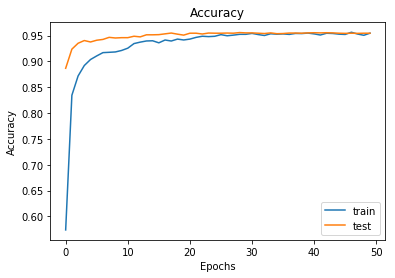

In [34]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

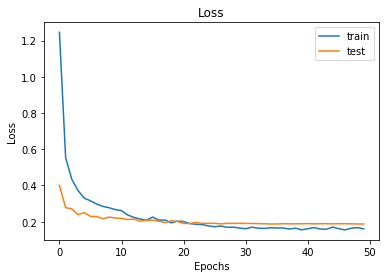

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

In [32]:
model2.save('dr_solved2.h5')

---

## Analysing misclassified images

In [35]:
df = pd.read_csv('data/test.csv', header=None, index_col=None)

In [37]:
df.shape

(1156, 785)

In [131]:
x, y = df.iloc[:, 1:], df.iloc[:, 0]
x = x / 255.

In [132]:
x = x.values.reshape(-1, 28, 28, 1)

In [133]:
pred, pred_class = model2.predict(x), model2.predict_classes(x)

In [134]:
print(classification_report(y, pred_class))

              precision    recall  f1-score   support

           1       0.74      0.98      0.84       129
           2       0.99      0.95      0.97       139
           3       0.99      0.96      0.98       123
           4       0.98      0.94      0.96       124
           5       0.96      0.95      0.96       127
           6       0.99      0.93      0.96       117
           7       0.99      0.94      0.97       125
           8       0.98      0.94      0.96       147
           9       0.98      0.93      0.95       125

   micro avg       0.95      0.95      0.95      1156
   macro avg       0.96      0.95      0.95      1156
weighted avg       0.96      0.95      0.95      1156



In [135]:
print(confusion_matrix(y, pred_class))

[[127   1   1   0   0   0   0   0   0]
 [  7 132   0   0   0   0   0   0   0]
 [  4   0 118   0   1   0   0   0   0]
 [  5   0   0 116   1   1   0   0   1]
 [  5   0   0   0 121   0   0   1   0]
 [  4   0   0   0   1 109   1   1   1]
 [  7   0   0   0   0   0 118   0   0]
 [  8   0   0   1   0   0   0 138   0]
 [  5   0   0   1   2   0   0   1 116]]


In [136]:
pred = np.max(pred, axis=1)

In [137]:
errors = y != pred_class

(array([33.,  4.,  3.,  1.,  1.,  1.,  1.,  2.,  4., 11.]),
 array([0.27648187, 0.3488185 , 0.42115515, 0.49349177, 0.56582844,
        0.63816506, 0.7105017 , 0.78283834, 0.85517496, 0.92751163,
        0.99984825], dtype=float32),
 <a list of 10 Patch objects>)

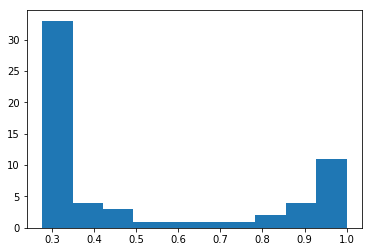

In [141]:
plt.hist(pred[errors])

In [144]:
len(pred[errors]), sum(pred[errors] > 0.5)

(61, 21)

## Checking performance on noisy image

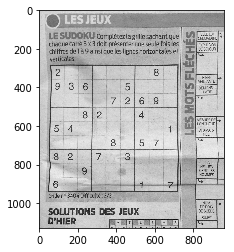

In [145]:
img = cv2.imread('data/train/image1049.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

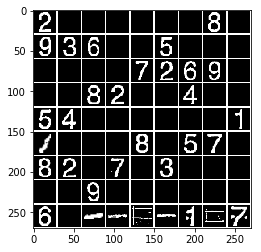

In [146]:
digits = ip_utils.convert(img)
plt.imshow(ip_utils.display_digits(digits), cmap='gray')

In [152]:
bot_row = np.array(digits[-9:]) / 255.

In [153]:
bot_row = bot_row.reshape(-1, 28, 28, 1)

In [154]:
bot_row.shape

(9, 28, 28, 1)

In [155]:
pred = model2.predict(bot_row)

In [162]:
np.argmax(pred, axis=1)

array([6, 1, 5, 5, 2, 5, 1, 2, 7], dtype=int64)

In [163]:
np.max(pred, axis=1)

array([0.9999597 , 0.33316475, 0.6785244 , 0.20950122, 0.17176643,
       0.1854076 , 0.96871537, 0.14751741, 0.99996006], dtype=float32)

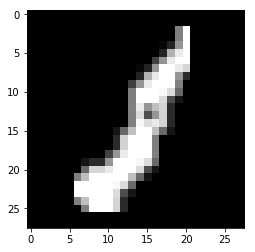

In [164]:
plt.imshow(digits[45], cmap='gray')

In [184]:
max(model2.predict(digits[45].reshape(1, 28, 28, 1))[0])

1.0